# Tutorial 4: MBHBs & MCMC

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful
from lisatools.utils.constants import *

In the fourth tutorial we will examine MBHB waveforms. We will examine how to generate waveforms, add the LISA response, calculate the Likelihood, and then we will run an MCMC with MBHBs. 

在第四个教程中我们将研究MBHB波形。我们将研究如何生成波形，添加LISA相应，计算似然，最后运行带有MBHB的MCMC。

## Task 1: Generate IMRPhenomHM waveforms 生成IMRPhenomHM波形

We will start by generating IMRPhenomHM waveforms for MBHBs. Pick reasonable parameters, build a waveform and plot it against the LISA Sensitivity Curve (`LISASens`) in the characteristic strain representation. **Hint**: set `f_ref = 0.0`. You can access the information after waveform generation as attributes on the class. This may be updated.

我们将从生成MBHB的IMRPhenomHM开始。选择合适的参数，建立一个波形并且将其绘制在特征应变表示的LISA灵敏度曲线上。提示：设置f_ref = 0.0。可以在波形生成之后作为类的属性来访问这些属性并且可以更新。

Useful documentation:
* [PhenomHMAmpPhase](https://mikekatz04.github.io/BBHx/html/user/waveforms.html#bbhx.waveforms.phenomhm.PhenomHMAmpPhase)

In [5]:
# imports 
from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
from lisatools.sensitivity import get_sensitivity

No CuPy or GPU PhenomHM module.


Text(0, 0.5, 'Characteristic Strain')

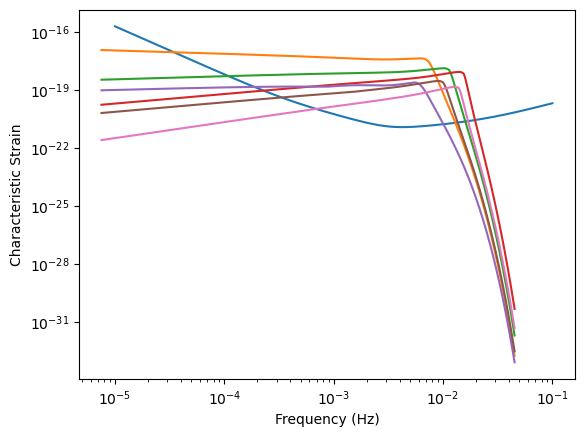

In [6]:
wave_gen = PhenomHMAmpPhase()

m1 = 2e6
m2 = 7e5
chi1 = 0.5
chi2 = 0.7
dist = 15 * 1e9 * PC_SI
phi_ref = 0.6
f_ref = 0.0
t_ref = 1e6 # seconds
length = 1024

wave_gen(m1, m2, chi1, chi2, dist, phi_ref, f_ref, t_ref, length)


fn = np.logspace(-5, -1, 10000)
Sn_char_strain = get_sensitivity(fn, sens_fn="LISASens", return_type="char_strain") 


plt.loglog(fn, Sn_char_strain)
for i in range(6):
    char_strain = wave_gen.freqs * wave_gen.amp[0, i]
    plt.loglog(wave_gen.freqs, char_strain)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")

## Task 2: Add the response. 

Now repeat the same task as above by adding the response. In `BBHx`, the response is added automatically for you using the main waveform production class: `BBHWaveformFD`. The sensitivity for this should be `A1TDISens`.

在上面相同的任务下重复并添加相应。在BBHx中，如果使用主波形产生类BBHWaveformFD则会自动添加响应，它的灵敏度应该为A1TDISens。

Useful Documentation 参考文档:
* [BBHWaveformFD](https://mikekatz04.github.io/BBHx/html/user/main.html#bbhx.waveformbuild.BBHWaveformFD)

In [7]:
# imports
from bbhx.waveformbuild import BBHWaveformFD

No CuPy
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


In [9]:
tdi_wave_gen = BBHWaveformFD()

m1 = 2e6
m2 = 7e5
chi1 = 0.5
chi2 = 0.7
dist = 15 * 1e9 * PC_SI
phi_ref = 0.6
f_ref = 0.0
inc = np.pi / 8
lam = 3.4
beta = -0.7
psi = np.pi/4
t_ref = 1e6 # seconds

length = 1024

# setup data holders
Tobs = YRSID_SI / 12.  # 1 month
dt = 10.0  # sec
N = int(Tobs / dt)
Tobs = N * dt

freqs = np.fft.rfftfreq(N, dt)

AET = tdi_wave_gen(
    m1,
    m2, 
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    length=1024, 
    combine=False,  # TODO: check this
    direct=False,
    fill=True,
    squeeze=True,
    freqs=freqs
)

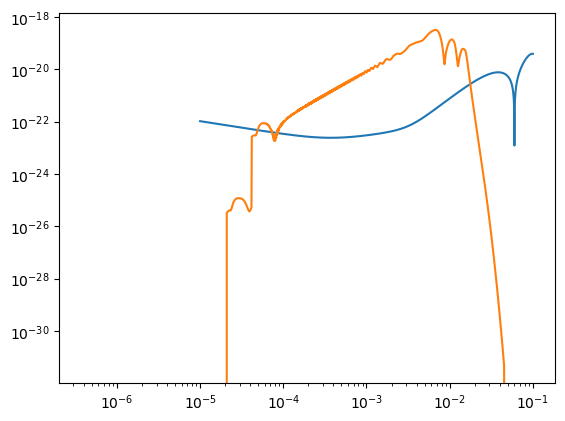

In [10]:
fn = np.logspace(-5, -1, 10000)
Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
plt.loglog(fn, Sn_char_strain)
plt.loglog(freqs, freqs * np.abs(AET[0,0]))

## Task 3: Inject an MBHB and compute its SNR 注入一个MBHB并计算其信噪比

Now we will combine our knowledge of `lisatools` with `bbhx`. Using the same methods above, setup a full `AnalysisContainer` and inject an MBHB signal. Calculate its SNR. You will probably need to wrap the MBHB waveform generation to select out just the 1st array entry. 

现在我们结合lisatools和bbhx的知识。使用相同的方法。设置一个完整的AnalysisContainer并注入一个MBHB信号，计算其信噪比，你可能需要包装MBHB的波形生成去只选择第一个数组输入。

In [11]:
# imports
from lisatools.sensitivity import AET1SensitivityMatrix
from lisatools.datacontainer import DataResidualArray
from lisatools.analysiscontainer import AnalysisContainer

In [12]:
def wrap(*args, **kwargs):
    return tdi_wave_gen(*args, **kwargs)[0]



data = DataResidualArray(AET[0], f_arr=freqs)
sens_mat = AET1SensitivityMatrix(data.f_arr)
analysis = AnalysisContainer(data, sens_mat, signal_gen=wrap)

/home/joyrich/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/home/joyrich/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/home/joyrich/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/home/joyrich/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/home/joyrich/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:94: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0 * np.pi *

In [13]:
analysis.snr()

3233.4754750915417

Calculate the Likelihood using `calculate_signal_likelihood`. 

利用calculate_signal_likelihood计算似然。

In [14]:
analysis.calculate_signal_likelihood(
    m1 * 1.0001,
    m2, 
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    waveform_kwargs=dict(
        length=1024, 
        combine=False,  # TODO: check this
        direct=False,
        fill=True,
        squeeze=True,
        freqs=freqs
    ),
    source_only=True
    # data_arr_kwargs=dict(f_arr=freqs)
)

-7.643172532320023

## Task 4: MCMC with MBHBs

Now we will run an MCMC for MBHBs. Use your knowledge from our tutorial on `Eryn` to run an MCMC for MBHBs. Let's run it for over four parameters: `(m1, m2, phi_ref, t_ref)`. You can use an `Eryn` [TransformContainer](https://mikekatz04.github.io/Eryn/html/user/utils.html#transformcontainer) or a wrapper Likelihood to fill in fixed parameters. You can use the `periodic` kwarg for `EnsembleSampler` to run `phi_ref` as a periodic variable wrapping over the edge.

现在我们将为MBHB运行MCMC，使用我们ERyn教程中的知识，调用四个参数(m1, m2, phi_ref, t_ref)。可以使用Eryn TransformContainer 或包装器似然来填充固定的参数。可以使用EnsembleSampler中的periodic关键字参数作为在边缘上包装的周期性变量来运行phi_ref。


This will not be fast. Run the sampler for a small number of samples and move on to the next step. 

这并不会很快。运行采样器进行少量的采样然后进入下一步。

In [15]:
# imports
from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State

In [16]:
def wrapper_likelihood(x, fixed_parameters, freqs, analysis, **kwargs):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)
    all_parameters[5] = x[2]
    all_parameters[-1] = x[3]

    all_parameters[np.array([2, 3, 4, 6, 7, 8, 9, 10])] = fixed_parameters

    ll = analysis.calculate_signal_likelihood(
        *all_parameters,
        waveform_kwargs=dict(
            length=1024, 
            combine=False,  # TODO: check this
            direct=False,
            fill=True,
            squeeze=True,
            freqs=freqs
        ),
        source_only=True
        # data_arr_kwargs=dict(f_arr=freqs)
    )
    return ll

In [17]:
priors = {"mbh": ProbDistContainer({
    0: uniform_dist(1e5, 5e6),
    1: uniform_dist(0.05, 0.999999),
    2: uniform_dist(0.0, 2 * np.pi),
    3: uniform_dist(0.0, Tobs + 24 * 3600.0),
})}

injection_params = np.array([
    m1 + m2,
    m2 / m1,
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref
])

fixed_parameters = np.array([
    chi1,
    chi2,
    dist, 
    f_ref, 
    inc,
    lam,
    beta,
    psi,
])

periodic = {"mbh": {2: 2 * np.pi}}

ntemps = 10
nwalkers = 32
ndims = {"mbh": 4}
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    wrapper_likelihood,
    priors,
    args=(fixed_parameters, freqs, analysis),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
    periodic=periodic
)

In [18]:
injection_params

array([ 2.70000000e+06,  3.50000000e-01,  5.00000000e-01,  7.00000000e-01,
        4.62851637e+26,  6.00000000e-01,  0.00000000e+00,  3.92699082e-01,
        3.40000000e+00, -7.00000000e-01,  7.85398163e-01,  1.00000000e+06])

In [19]:
injection_params_sub = np.array([m1 + m2, m2 / m1, phi_ref, t_ref])
start_params = injection_params_sub[None, None, None, :] * (1 + 1e-4 * np.random.randn(ntemps, nwalkers, 1, injection_params_sub.shape[0]))
start_state = State({"mbh": start_params})
sampler.compute_log_prior(start_state.branches_coords)
sampler.run_mcmc(start_state, 10, progress=True)

100%|██████████| 10/10 [04:29<00:00, 26.96s/it]


## Task 5: Add heterodyning for speed 利用外差加速

That would take a long time to complete a sampling run. One technique for speeding up waveforms is called `heterodyning`. Wrap the Heterodyned likelihood to use a subset of parameters. You can also use an Eryn `TransformFunction`. 

这将需要很长时间来完成一次采样运行。外差是一种加速波形的技术。包装外差似然以使用参数子集。你也可以使用Eryn的TransformFunction。

Useful Documentation 参考文档:

* [HeterodynedLikelihood](https://mikekatz04.github.io/BBHx/html/user/like.html#bbhx.likelihood.HeterodynedLikelihood)

In [20]:
# imports
from bbhx.likelihood import HeterodynedLikelihood

No CuPy


In [21]:
# how many frequencies to use
length_f_het = 128

mT = injection_params[0]
q = injection_params[1]

transformed_injection_params = injection_params.copy()
transformed_injection_params[0] = mT / (1 + q)
transformed_injection_params[1] = mT * q / (1 + q)
# initialize Likelihood
like_het = HeterodynedLikelihood(
    tdi_wave_gen,
    freqs,
    data[:],
    transformed_injection_params,
    length_f_het,
)

like_het.get_ll(transformed_injection_params[None, :].T)

array([-0.00275878])

In [22]:
def het_wrapper_likelihood(x, fixed_parameters, freqs, het_like):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)

    # 
    all_parameters[5] = x[2]
    all_parameters[-1] = x[3]

    all_parameters[np.array([2, 3, 4, 6, 7, 8, 9, 10])] = fixed_parameters

    ll = like_het.get_ll(all_parameters)
    return ll

In [23]:
injection_params

array([ 2.70000000e+06,  3.50000000e-01,  5.00000000e-01,  7.00000000e-01,
        4.62851637e+26,  6.00000000e-01,  0.00000000e+00,  3.92699082e-01,
        3.40000000e+00, -7.00000000e-01,  7.85398163e-01,  1.00000000e+06])

In [24]:
ll_comp = wrapper_likelihood(injection_params[np.array([0, 1, 5, 11])], fixed_parameters, freqs, analysis)
ll_het = het_wrapper_likelihood(injection_params[np.array([0, 1, 5, 11])], fixed_parameters, freqs, like_het)
print(ll_het, ll_comp)

[-0.00275878] -0.0


Let's check how well the heterodyning method matches the base likelihood by sampling our prior. You will have to update the reference template for each computation since we are drawing from the prior and may be far away from our true point. You can do this with `HeterodynedLikelihood.init_heterdyne_info`. 

让我们通过抽样我们的先验来检查外差方法与基本似然的匹配程度。你必须为每个计算更新参考模板，因为我们是从先验来画图因此有可能远离我们的真实点。你可以通过使用HeterodynedLikelihood.init_heterdyne_info来完成。

In [25]:
num = 10
for params in priors["mbh"].rvs(num):
    update_params = injection_params.copy()
    mT = params[0]
    q = params[1]
    m1 = mT / (1 + q)
    m2 = mT * q / (1 + q)
    update_params[np.array([0, 1, 5, 11])] = np.array([m1, m2, params[2], params[3]])
    like_het.init_heterodyne_info(
        update_params
    )
    ll_comp = wrapper_likelihood(params, fixed_parameters, freqs, analysis)
    ll_het = het_wrapper_likelihood(params, fixed_parameters, freqs, like_het)
    print(ll_comp, ll_het, np.abs(ll_comp - ll_het), np.abs(ll_comp - ll_het) / np.abs(ll_comp))

-6470793.350270055 [-6470791.19002267] [2.16024739] [3.33845831e-07]
-11987194.920372667 [-11987194.93549009] [0.01511742] [1.26113104e-09]
-22336509.06909914 [-22336509.70982115] [0.64072201] [2.86849665e-08]
-22846703.468517676 [-22846698.7655874] [4.70293028] [2.05847215e-07]
-10135828.692707425 [-10135828.35009812] [0.34260931] [3.38018052e-08]
-11564622.852516208 [-11564623.54918492] [0.69666871] [6.02413691e-08]
-5860131.2045881 [-5860126.67501838] [4.52956972] [7.7294681e-07]
-12101830.112295428 [-12101829.5397327] [0.57256273] [4.73120781e-08]
-6580404.071332426 [-6580403.74036732] [0.33096511] [5.02955601e-08]
-17810264.945787627 [-17810263.04399419] [1.90179344] [1.06780749e-07]


In [26]:
nwalkers = 32
het_sampler = EnsembleSampler(
    nwalkers,
    ndims,
    het_wrapper_likelihood,
    priors,
    args=(fixed_parameters, freqs, like_het),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    periodic=periodic
)

In [27]:
injection_params_sub = np.array([m1 + m2, m2 / m1, phi_ref, t_ref])
start_params = injection_params_sub[None, None, None, :] * (1 + 1e-7 * np.random.randn(ntemps, nwalkers, 1, 4))
start_params[:, :, :, 2] %= (2 * np.pi)
het_start_state = State({"mbh": start_params})
het_sampler.backend.reset(*het_sampler.backend.reset_args,**het_sampler.backend.reset_kwargs)
het_sampler.run_mcmc(het_start_state, 1000, burn=200, progress=True)

100%|██████████| 1000/1000 [03:29<00:00,  4.78it/s]


In [28]:
het_sampler.compute_log_like(het_start_state.branches_coords)

(array([[-13568504.53559352, -13568457.09547961, -13568558.51495419,
         -13568543.84604122, -13568507.27984637, -13568440.18902043,
         -13568480.97963348, -13568473.37462275, -13568469.92278773,
         -13568484.47221613, -13568480.66029389, -13568509.57609382,
         -13568472.577575  , -13568499.74947016, -13568461.71523024,
         -13568471.55890562, -13568538.80331171, -13568496.28891465,
         -13568420.00396308, -13568471.90716191, -13568454.62143197,
         -13568520.57422047, -13568437.51028743, -13568515.04011185,
         -13568542.30824051, -13568474.38692908, -13568496.88503413,
         -13568491.1508196 , -13568472.51929807, -13568462.52870049,
         -13568508.73697645, -13568521.04209974],
        [-13568467.53848252, -13568427.04380938, -13568487.23649448,
         -13568503.37088717, -13568459.51973754, -13568460.39076476,
         -13568466.57578772, -13568535.71584002, -13568527.01849987,
         -13568425.29361884, -13568502.60051442, -135

Parameter phi_ref in chain An Example Contour is not constrained
Parameter t_ref in chain An Example Contour is not constrained


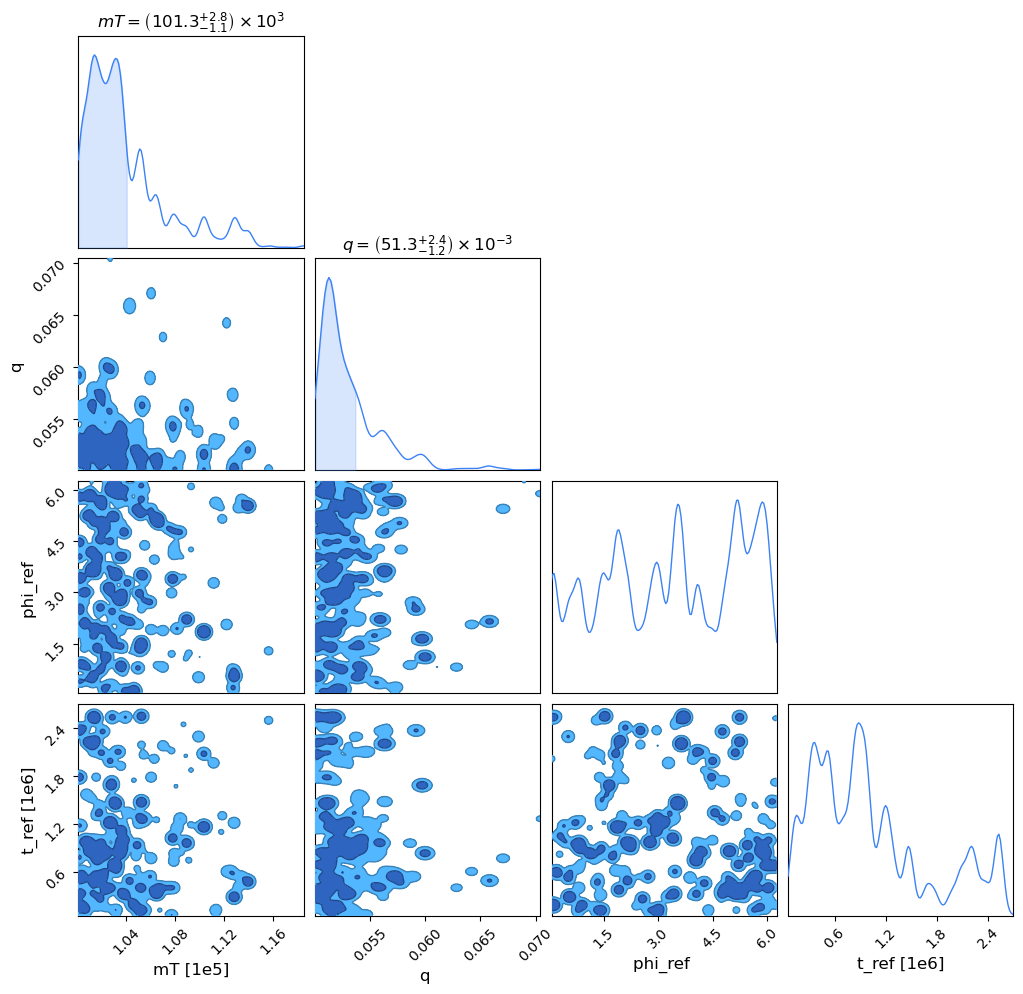

In [29]:
from chainconsumer import Chain, ChainConsumer, make_sample
import pandas as pd
samples = het_sampler.get_chain()["mbh"][:, 0].reshape(-1, 4)
df = pd.DataFrame(samples, columns=["mT", "q", "phi_ref", "t_ref"])
c = ChainConsumer()
c.add_chain(Chain(samples=df, name="An Example Contour"))
fig = c.plotter.plot()

In [30]:
het_sampler.get_log_like().max(axis=(1, 2))

array([-5230062.24490341, -5230062.24490341, -5230062.24490341,
       -5230062.24490341, -5230062.24490341, -5230062.24490341,
       -5230062.24490341, -5230062.24490341, -5230062.24490341,
       -5230062.24490341, -5230062.24490341, -5230062.24490341,
       -5230062.24490341, -5230062.24490341, -5230062.24490341,
       -5230062.24490341, -5230062.24490341, -5230062.24490341,
       -5230062.24490341, -5230062.24490341, -5230062.24490341,
       -5230062.24490341, -5230062.24490341, -5230062.24490341,
       -5230062.24490341, -5230062.24490341, -5230062.24490341,
       -5230062.24490341, -5230062.24490341, -5230062.24490341,
       -5230062.24490341, -5230062.24490341, -5230062.24490341,
       -5230062.24490341, -5230062.24490341, -5230062.24490341,
       -5230062.24490341, -5230062.24490341, -5230062.24490341,
       -5230062.24490341, -5230062.24490341, -5230062.24490341,
       -5229999.27571828, -5229999.27571828, -5229999.27571828,
       -5229999.27571828, -5229855.01417

In [31]:
het_sampler.get_log_like()[-1]

array([[-5229746.66327965, -5229714.99011963, -5229681.45672904,
        -5229689.072151  , -5229394.8457766 , -5229758.20163329,
        -5229789.95523888, -5229592.50509388, -5229776.93539376,
        -5229774.96925753, -5229197.38257999, -5229579.15171043,
        -5229586.86807836, -5229653.78688445, -5229702.99940113,
        -5229764.75072056, -5229668.69406442, -5229678.98088433,
        -5229664.38699611, -5229783.26196369, -5229746.61329942,
        -5229640.9001248 , -5229699.72362473, -5229572.26192012,
        -5229761.52560642, -5229780.69464518, -5229785.2100904 ,
        -5229757.92258845, -5229580.16623633, -5229603.86176819,
        -5229473.6429046 , -5229744.29213948],
       [-5229908.23665624, -5229919.09068089, -5229839.99867128,
        -5229819.89259073, -5229902.91440829, -5229898.12882513,
        -5229795.80194505, -5229902.17710445, -5229880.39239154,
        -5229854.44622381, -5229834.43213325, -5229856.51324883,
        -5229818.52878816, -5229813.2845874

Setup and run the sampler. Then plot the posteriors using `ChainConsumer` or `corner`.

设置好并运行采样器。然后使用ChainConsumer或corner来绘制后验图。

## 学习总结

对大质量黑洞双星研究了波形的生成，LISA响应的添加，计算了似然，运行了黑洞双星的蒙特卡洛算法。

计算了黑洞双星下的信噪比。

添加外差进行了波形计算的加速，虽然不知道原理是什么。画图直观地检验了匹配程度。